# Imports

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
from skimage import feature
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from keras.optimizers import Adam
from keras.preprocessing.image import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input

# Pre-procesamiento del Dataset

In [2]:
BASE_DIR = './UTKFace'

image_paths = []
age_labels = []

i = 0
for filename in os.listdir(BASE_DIR):
    image_path = os.path.join(BASE_DIR, filename)
    image_paths.append(image_path)

    temp = filename.split('_')
    age = int(temp[0])
    age_labels.append(age)
    i+=1

df = pd.DataFrame()
df['image'], df['age'] = image_paths, age_labels
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23708 entries, 0 to 23707
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   23708 non-null  object
 1   age     23708 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 370.6+ KB


In [3]:
df.head()

,image,age
0,./UTKFace\100_0_0_20170112213500903.jpg.chip.jpg,100
1,./UTKFace\100_0_0_20170112215240346.jpg.chip.jpg,100
2,./UTKFace\100_1_0_20170110183726390.jpg.chip.jpg,100
3,./UTKFace\100_1_0_20170112213001988.jpg.chip.jpg,100
4,./UTKFace\100_1_0_20170112213303693.jpg.chip.jpg,100


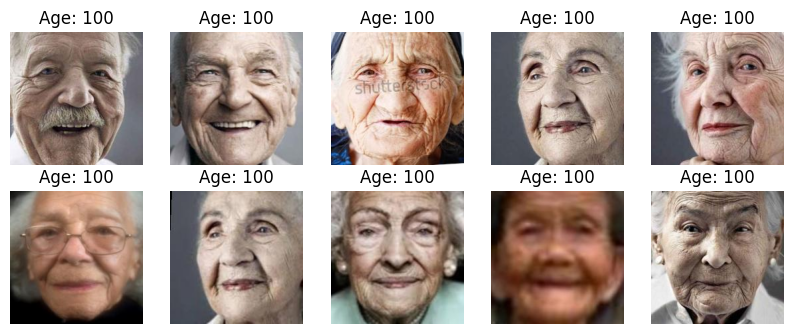

In [4]:
plt.figure(figsize=(10, 10))
files = df.iloc[0:10]

for index, file, age in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(f"Age: {age}")
    plt.axis('off')

C:\Users\dani08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\dani08\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='age', ylabel='Count'>

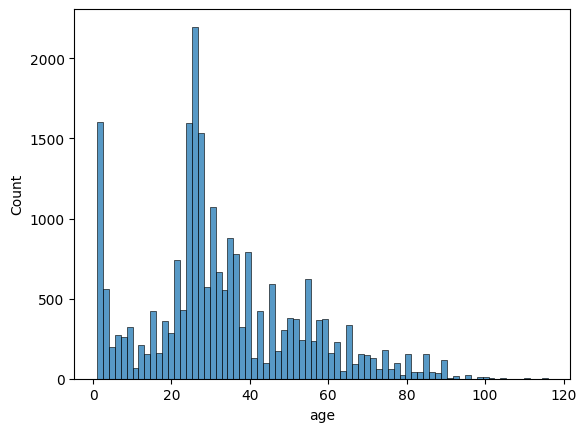

In [5]:
sns.histplot(df['age'])

# Feature Engineering

In [3]:
def image_processing(images):
    features = []
    for image in images:
        img = load_img(image, color_mode="grayscale")
        img = img.resize((128, 128), Image.NONE)
        img = np.array(img)
        features.append(img)
        
    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

X_raw = image_processing(df['image'])
np.shape(X_raw)

(23708, 128, 128, 1)

# Feature Extractor

### Local Binary Patterns

In [11]:
X_lbp = np.copy(X_raw)

for i in range(len(X_lbp)):
    lbp_image = feature.local_binary_pattern(X_lbp[i, :, :, 0], P=8, R=1, method="uniform")
    lbp_image = lbp_image.astype(np.uint8)
    X_lbp[i, :, :, 0] = lbp_image

### SIFT

In [46]:
sift = cv2.SIFT_create()

descriptor_size = 128
X_sift = []

for i in range(len(X_raw)):
    grayscale_image = X_raw[i, :, :, 0].astype(np.uint8)  # Convert to uint8
    key_points, descriptors = sift.detectAndCompute(grayscale_image, None)

    # Check if there are enough keypoints for this image
    if descriptors is not None:
        # If the number of keypoints is less than descriptor_size, we'll pad with zeros
        if descriptors.shape[0] < descriptor_size:
            descriptors = np.vstack([descriptors, np.zeros((descriptor_size - descriptors.shape[0], descriptors.shape[1]), 
                                                           dtype=np.float32)])
        # If there are more keypoints, we'll truncate
        elif descriptors.shape[0] > descriptor_size:
            descriptors = descriptors[:descriptor_size, :]

        X_sift.append(descriptors)
    else:
        # If there are no keypoints detected, you can add a placeholder array of zeros
        X_sift.append(np.zeros((descriptor_size, 128), dtype=np.float32))

X_sift = np.array(X_sift)

### ORB

In [57]:
orb = cv2.ORB_create()

X_orb = []

for i in range(len(X_raw)):
    grayscale_image = X_raw[i, :, :, 0].astype(np.uint8)  # Convert to uint8
    key_points, descriptors = orb.detectAndCompute(grayscale_image, None)

    # Check if there are enough keypoints for this image
    if descriptors is not None:
        # If the number of keypoints is less than descriptor_size, we'll pad with zeros
        if descriptors.shape[0] < descriptor_size:
            descriptors = np.vstack([descriptors, np.zeros((descriptor_size - descriptors.shape[0], descriptors.shape[1]), 
                                                           dtype=np.float32)])
        # If there are more keypoints, we'll truncate
        elif descriptors.shape[0] > descriptor_size:
            descriptors = descriptors[:descriptor_size, :]

        X_orb.append(descriptors)
    else:
        # If there are no keypoints detected, you can add a placeholder array of zeros
        X_orb.append(np.zeros((descriptor_size, 32), dtype=np.float32))

# Convert the list of ORB descriptors to a NumPy array
X_orb = np.array(X_orb)

### HoG

In [62]:
X_hog = []

for i in range(len(X_raw)):
    # Compute HOG features
    hog_features = feature.hog(X_raw[i, :, :, 0], orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=False)

    X_hog.append(hog_features)

X_hog = np.array(X_hog)

### Bilateral Filter

In [64]:
X_bilateral = []

for i in range(len(X_raw)):
    img = X_raw[i, :, :, 0]
    img = cv2.bilateralFilter(img, 9, 75, 75)
    X_bilateral.append(img)

X_bilateral = np.array(X_bilateral)

# División en Train / Test Sets

In [65]:
print(X_raw.shape)
print(X_lbp.shape)
print(X_sift.shape)
print(X_orb.shape)
print(X_hog.shape)
print(X_bilateral.shape)

(23708, 128, 128, 1)
(23708, 128, 128, 1)
(23708, 128, 128)
(23708, 128, 32)
(23708, 512)
(23708, 128, 128)


In [74]:
y = np.array(df['age'])

# División de set de datos
# Imágenes crudas
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, y, test_size=0.2, random_state=42)

# Imágenes con Feature Extractor
X_train_lbp, X_test_lbp, y_train_lbp, y_test_lbp = train_test_split(X_lbp, y, test_size=0.2, random_state=42)
X_train_sift, X_test_sift, y_train_sift, y_test_sift = train_test_split(X_sift, y, test_size=0.2, random_state=42)
X_train_orb, X_test_orb, y_train_orb, y_test_orb = train_test_split(X_orb, y, test_size=0.2, random_state=42)
X_train_hog, X_test_hog, y_train_hog, y_test_hog = train_test_split(X_hog, y, test_size=0.2, random_state=42)

# Imágenes con Bilateral Filter
X_train_bilat, X_test_bilat, y_train_bilat, y_test_bilat = train_test_split(X_bilateral, y, test_size=0.2, random_state=42)

## Encoding según grupo de edad

In [75]:
y_train_raw_group = []
y_test_raw_group = []
y_train_bilat_group = []
y_test_bilat_group = []

def encode_ages(new_list, ages):
    for age in ages:
        if age < 12:
            new_list.append(0)
        elif age < 19:
            new_list.append(1)
        elif age < 60:
            new_list.append(2)
        else:
            new_list.append(3)
    return np.array(new_list)

y_train_raw_group = encode_ages(y_train_raw_group, y_train_raw)
y_test_raw_group = encode_ages(y_test_raw_group, y_test_raw)
y_train_bilat_group = encode_ages(y_train_bilat_group, y_train_bilat)
y_test_bilat_group = encode_ages(y_test_bilat_group, y_test_bilat)

# MLP

## Sin Feature Extractor

### Entrenamiento

In [77]:
model = Sequential([
    Flatten(input_shape=(128, 128)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='linear')
])
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

history = model.fit(X_train_raw, y_train_raw, validation_split=0.2, epochs=100, batch_size=64)

238/238 [==============================] - 67s 198ms/step - loss: 1495.4060 - mae: 33.2217 - val_loss: 1534.8442 - val_mae: 33.4774


In [ ]:
plt.figure(figsize=(5, 5))
plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.legend()

### Predicción de Edad

In [80]:
y_pred = model.predict(X_test_raw)
y_pred_train = model.predict(X_train_raw)

test_mae = np.mean(np.abs(y_test_raw - y_pred))
train_mae = np.mean(np.abs(y_train_raw - y_pred_train)) #TODO: revisar memory error
print(f"Test MAE: {test_mae}")
print(f"Train MAE: {train_mae}")

In [ ]:
df_test = pd.DataFrame()
df_test['Real Ages'] = y_test_raw
df_test['Predicted Ages'] = y_pred
df_test.head(10)

### Clasificación en grupos de edad

In [ ]:
y_pred_group = []
y_train_pred_group = []

y_pred_group = encode_ages(y_pred_group, y_pred)
y_train_pred_group = encode_ages(y_train_pred_group, y_pred_train)

accuracy = accuracy_score(y_test_raw_group, y_pred_group)
precision = precision_score(y_test_raw_group, y_pred_group, average='weighted')
recall = recall_score(y_test_raw_group, y_pred_group, average='weighted')
f1 = f1_score(y_test_raw_group, y_pred_group, average='weighted')

accuracy_train = accuracy_score(y_train_raw_group, y_train_pred_group)
precision_train = precision_score(y_train_raw_group, y_train_pred_group, average='weighted')
recall_train = recall_score(y_train_raw_group, y_train_pred_group, average='weighted')
f1_train = f1_score(y_train_raw_group, y_train_pred_group, average='weighted')

results = pd.DataFrame()
results['Test'] = [accuracy, precision, recall, f1]
results['Train'] = [accuracy_train, precision_train, recall_train, f1_train]
results.index = ['Accuracy', 'Precision', 'Recall', 'F1']
results

## Con Feature Extractor

In [ ]:
model = Sequential([
    # Flatten the input image (128x128)
    Flatten(input_shape=(128, 128)), #TODO: fix shape depending on feature extractor
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='linear')
])
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

history = model.fit(X_train_raw, y_train_raw, validation_split=0.2, epochs=1, batch_size=64)

# CNN

## Sin Bilateral Filter

## Con Bilateral Filter